# Fill sinks in a digital elevation model (DEM)
Filling sinks in a DEM is an important preprocessing step in hydrological and soil erosion modelling.

**But what is a DEM?** Imagine you have a map of a hilly area, like a model of a miniature landscape made out of LEGO pieces. Each lego piece represents a point on the terrain (i.e. a cell of the DEM), and its height corresponds to the elevation at that point. Some blocks are stacked higher, representing hills or mountains, while others are lower, representing valleys or plains. Now, imagine pouring water onto this LEGO terrain. Just like in real life, some spots might act like little bowls, where water collects because they're surrounded by higher LEGO blocks on all sides. These are our "sinks" - the places where water would naturally accumulate.

<left><img src="images/dem_lego.png" width="800px">

**Why filling sinks is important?** Sinks in a DEM represent areas where water can accumulate but not flow out. Filling sinks ensures a continuous and realistic representation of surface water flow, which is essential for hydrological modeling.

##### Code: `Import libraries`

In [1]:
import numpy as np             # NumPy is a library for numerical computing in Python.
import pandas as pd            # Pandas is a library for data manipulation and analysis.
import plotly.express as px    # Plotly Express is a high-level interface for creating interactive visualizations.
import rasterio                # Rasterio is a library for reading and writing geospatial raster data.
from ipywidgets import widgets, interact # ipywidgets provides interactive HTML widgets for Jupyter notebooks.
import glob                    # The glob module provides a function for Unix-style pathname pattern expansion.
import numba                   # Numba is a library for accelerating numerical computations.

## 2. Define the function to fill sinks in a DEM
First of all we define two **helper functions** to **Get the highest elevation among the neighbours** and .

### Get the highest elevation among the neighbours
This part of the code is like a little program that helps us find out which point on the map is the tallest among its nearby points. Think of it as looking at a hill and figuring out which spot on the hill is the highest compared to the spots around it. So, for every point on the map, we look at its immediate surroundings and find the highest point.

##### Code: `Helper function 1:get the highest neighbour`

In [8]:
@numba.jit
def elevation_highest_neighbour(x, y, dem):
    """
    Helper function to calculate the maximum elevation among neighbouring cells.

    Args:
    - x, y: coordinates of the cell in the DEM
    - dem: the DEM itself represented as a 2D NumPy array

    Returns:
    - max_elevation: maximum elevation among neighbours
    """
    
    rows, cols = dem.shape  # Retrieve the dimensions of the DEM (rows, cols)
    
    # Define the neighbourhood offsets (8-connected)
    neighbours = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]
    
    max_elevation = dem[x, y]
    for dx, dy in neighbours:
        nx, ny = x + dx, y + dy # It iterates over each neighbor
        # Check if neighbour is within bounds
        if 0 <= nx < rows and 0 <= ny < cols:
            max_elevation = max(max_elevation, dem[nx, ny])
    return max_elevation #Finally, it returns the maximum elevation among the neighboring cells.

### Check if a cell is a sink 
Imagine you pour water onto the map. Some points might be like little bowls, where water collects because they're surrounded by higher ground on all sides. These are called sinks. This part of the code helps us identify these sink points. It checks if a point on the map is surrounded by higher points on all sides, just like how water would collect in a little depression or hole in the ground.

##### Code: `Helper function 2: check if a cell is a sink`

In [2]:
@numba.jit
def is_sink(x, y, dem):
    """
    Helper function to check if a cell is a sink.

    Args:
    - x, y: Coordinates of the cell in the DEM
    - dem: the DEM itself represented as a 2D NumPy array

    Returns:
    - True if the cell is a sink, False otherwise
    """
    rows, cols = dem.shape  # Retrieve the dimensions of the DEM (rows, cols)
    
    # Define the neighbourhood offsets (8-connected)
    neighbours = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]
    
    for dx, dy in neighbours:
        nx, ny = x + dx, y + dy # It iterates over each neighbor
        # Check if neighbour is within bounds and if its elevation is <= the elevation of the current cell
        if 0 <= nx < rows and 0 <= ny < cols and dem[nx, ny] <= dem[x, y]:
            return False # the function returns False, indicating that the current cell is not a sink
    return True #If none of the neighbors satisfy the conditions, the current cell is a sink

### Function to fill the sinks of the DEM
First, it finds the lowest point on the map. Then, it goes through each point on the map and checks if it's a sink (where water would stop and get stored). If it finds a sink, it raises that point to the same height as the surrounding highest points. It keeps doing this until there are no more sinks left on the map. Essentially, it's like filling in low spots on the map to make sure water flows smoothly without getting stuck.

##### Code: `Main function that fill the sinks of the DEM`

In [9]:
@numba.jit
def fill_sinks(dem):
    """
    Function to fill sinks in a Digital Elevation Model (DEM).
    
    Args:
    - dem: 2D numpy array representing the DEM
    
    Returns:
    - Filled DEM with sinks removed
    """
    rows, cols = dem.shape  # Get the dimensions of the DEM (rows, cols)

    while True:  # Repeat until no more sinks are found
        found_sinks = False
        min_elevation = np.inf
        
        # Calculate the minimum elevation
        for i in range(rows):
            for j in range(cols):
                if not np.isnan(dem[i, j]):  # Skip NaN values
                    min_elevation = min(min_elevation, dem[i, j])

        # Loop through each cell in the DEM
        for i in range(rows):
            for j in range(cols):
                # Check if the cell has elevation greater than the minimum in the DEM
                if not np.isnan(dem[i, j]) and dem[i, j] > min_elevation:
                    # Check if the cell is a sink
                    if is_sink(i, j, dem):
                        # Get the maximum elevation among neighbours
                        high_neighbour_elevation = elevation_highest_neighbour(i, j, dem)
                        # Replace the sink elevation with the maximum neighbour elevation
                        if dem[i, j] != high_neighbour_elevation:
                            dem[i, j] = high_neighbour_elevation
                            found_sinks = True  # Set the flag to True indicating that a sink has been filled
        # Break the loop if no more sinks are found
        if not found_sinks:
            break
    return dem

## 2. Load the data

<left><img src="images/file_to_dem.png" width="300px">

### Load the DEM raster
To load the DEM, we use a tool called `rasterio`. We're basically using `rasterio` to open up our digital map of the terrain  (also known as raster datasets) to extract information from them, such as the height of each cell, and perform various raster operations, finding out how steep a hill is or filling sinks. It also extract the `metadata` information such as the raster's spatial reference system and data type. You can use this metadata for various purposes, such as georeferencing and understanding the properties of the raster map.

##### Code: `Select the raster file`

In [4]:
files = [f for f in glob.glob('inputs/*.*')]
input_file = widgets.Select(
    options=files,
    description='select raster:',
    disabled=False
)
display(input_file)

Select(description='select raster:', options=('inputs\\dem_fill.tif', 'inputs\\DEM_Montefrio.tif'), value='inp…

##### Code: `Open the raster map file`

In [30]:
with rasterio.open(input_file.value) as src:
    # Read the raster data as a numpy array
    dem = src.read(1)  # Read the first band (index 0)

    # Get metadata of the raster map
    dem_metadata = src.meta

##### Code: `Plot the DEM`

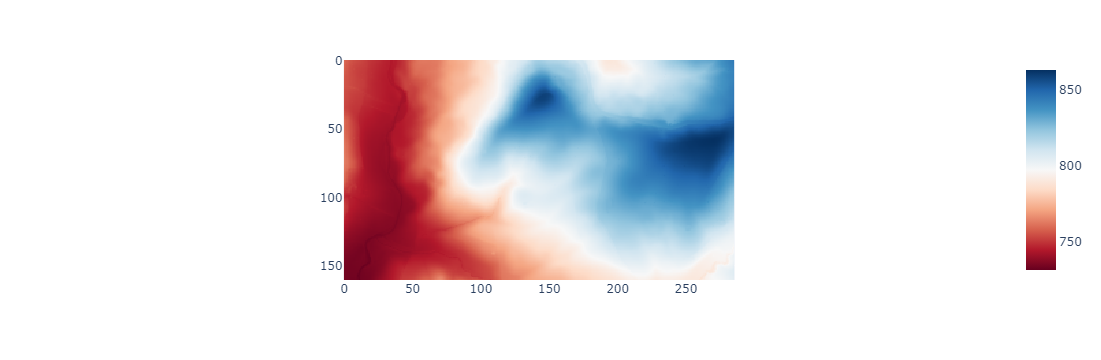

In [31]:
fig = px.imshow(dem,color_continuous_scale='rdbu')
fig.show()

## 3. Fill the sinks of the loaded DEM
In this step we finally perform the sink filling on the digital elevation model (DEM) and then we visualize the filled areas compared to the original DEM.

##### Code: `Run the function to fill the sinks and plot the filled areas`

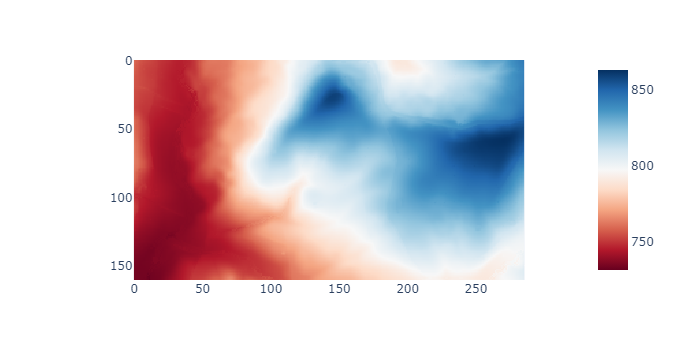

In [37]:
# The filled DEM is saved as dem_fill
dem_fill = fill_sinks(dem.copy())
# Plot only the filled areas (difference between the filled DEM and the original DEM)
fig = px.imshow(dem_fill,color_continuous_scale='rdbu')
fig.show()

## 4. Add noise to the flat areas of the DEM
Sometimes, there are areas on the map that are flat, in particular in the filled sinks. When it comes to water flowing across this map, these flat areas can be a bit tricky.

**Why are flat areas tricky?** Well, imagine pouring water onto these flat areas. Since all the points have the same height, the water doesn't know which way to go. It's like standing in the middle of a perfectly flat field and trying to decide which direction is downhill – there's no clear answer! 

<left><img src="images/water_flat.png" width="400px">

This ambiguity arises because the conventional methods for computing flow direction rely on the elevation difference between neighboring cells. In flat areas, there might not be a clear direction of flow, leading to incorrect flow direction assignment.

**How can we solve this problem?** we add a little bit of randomness to these flat areas. We're essentially making tiny bumps and dips in the flat spots, so the water has some guidance on which way to flow. This process helps us create a map where water flows smoothly across the landscape.

The function called `add_noise_to_flat_areas` does exactly that. It looks for these flat spots where all the points have the same height. Then, it adds a bit of random noise to each point in these spots. This noise makes the flat areas a little uneven, breaking the symmetry and helping water flow in a more natural way. 

In hydrological modeling, it's important to maintain hydrological connectivity, ensuring that water can flow continuously across the landscape. Adding noise to flat areas helps to break ties and establish a consistent flow path, improving the connectivity of the hydrological network.

##### Code: `Definition of the function to add noise to the flat areas`

In [33]:
def add_noise_to_flat_areas(dem, epsilon=0.001):
    """
    Adds noise to flat areas in a digital elevation model (DEM).

    Args:
        dem (numpy.ndarray): A 2D array representing the elevation data.
        epsilon (float): The magnitude of the noise to be added.

    Returns:
        dem (numpy.ndarray): The DEM with noise added to duplicate values.
    """

    # Find unique values and their counts in the DEM
    unique_values, counts = np.unique(dem, return_counts=True)
    # Identify duplicate values
    duplicates = unique_values[counts > 1]

    # Iterate over duplicate values
    for value in duplicates:
        # Find indices where the duplicate value occurs
        indices = np.where(dem == value)
        # Add noise to duplicate values
        # Note that the noise is negative to avoid creating new sinks
        noise = np.random.uniform(-epsilon, 0, size=len(indices[0]))
        dem[indices] += noise

    return dem

### Let's add the noise to the flat areas
Now, let's use the function to add a little bit of randomness to those flat areas.

We have something called "epsilon" (or epsilon), which is just a tiny positive number (like 0.0001). It's so small you can barely see it! This number decides how much randomness we add to the flat areas. We want just enough randomness to make our map look more realistic, but not too much that it changes everything.

So, by running this function with epsilon, we're basically giving our map a little shake-up to make it less flat.

In [34]:
# Set the value of epsilon, which represents the small amount of noise to be added
epsilon = 0.001
# Add noise to duplicates in the filled DEM using the add_noise_to_duplicates function
dem_fill = add_noise_to_flat_areas(dem_fill, epsilon)

The function iterates over the cells within the DEM to double check for potential sinks after adding the noise to the flat areas

In [35]:
def check_sinks(dem):
    rows, cols = dem.shape  # Get the dimensions of the DEM (rows, cols)
    found_sinks = False
    for i in range(rows):
        for j in range(cols):
            # Check if the cell has elevation greater than the minimum in the DEM
            if dem[i, j] > np.nanmin(dem):
                # Check if the cell is a sink
                if is_sink(i, j, dem):
                    # Get the maximum elevation among neighbours
                    high_neighbour_elevation = elevation_highest_neighbour(i, j, dem)
                    # Replace the sink elevation with the maximum neighbour elevation
                    if dem[i, j] != high_neighbour_elevation:
                        found_sinks = True # Set the flag to True indicating that a sink has been filled
                        # print("i = %d and j = %d" %(i,j))
    return found_sinks
check_sinks(dem_fill)

True

In [36]:
# Fill the sinks one more time
dem_fill = fill_sinks(dem_fill.copy())
check_sinks(dem_fill)

False

## 5. Save the filled DEM as a raster file
<left><img src="images/file_to_dem.png" width="300px">

You've just finished filling the sinks and now you want to keep a record of your work. For this purpose we also used the tool `rasterio`.

Just like how a photograph preserves the image you see, saving the filled DEM as a raster file preserves all the elevation data and changes you've made to the map. So, for the next modelling steps (or to share it with others), you can load the raster file (with `rasterio` as well), explore and modifiy the information over and over. 

In [22]:
# Specify the output file path
output_file = 'inputs/dem_fill.tif'

# Write the modified raster data to a new file with the same metadata
with rasterio.open(output_file, 'w', **dem_metadata) as dst:
    # Write the modified raster data to the new file
    dst.write(dem_fill, 1) 